In [66]:
import v123
import neuropythy as ny
import numpy as np
import scipy as sp

# Matplotlib is used for plotting
import matplotlib, matplotlib.pyplot as plt
%gui qt
%matplotlib inline

from ny.cortex import (cortex_plot, vertex_eccen_color, vertex_angle_color)

import os, sys, warnings, nibabel

# Aggregate Retinotopy Data

This section of the notebook briefly looks at the aggregate retinotopy data that was used to construct the anatomical template of retinotopy in both [Benson *et al.* (2012)](http://dx.doi.org/10.1016/j.cub.2012.09.014) and in [Benson *et al.* (2014)](http://dx.doi.org/10.1371/journal.pcbi.1003538). (This data is bundled together with the V123 project data.) We reanalyze it and refit the anatomical template of retinotopy here, and analyze how the resulting prediction of aggregate retinotopic maps in V1-V3 varies in terms of the parameters of the registration.

### Plots of the Aggregate Retinotopic Maps

These plots show the aggregate polar angle and eccentricity values of the retinotopic maps; transparency of the maps with respect to the curvature underlay is calculated according to the weight of each vertex, which is inversely proportional to the standard deviation of the polar angle and eccentricity values across subjects.

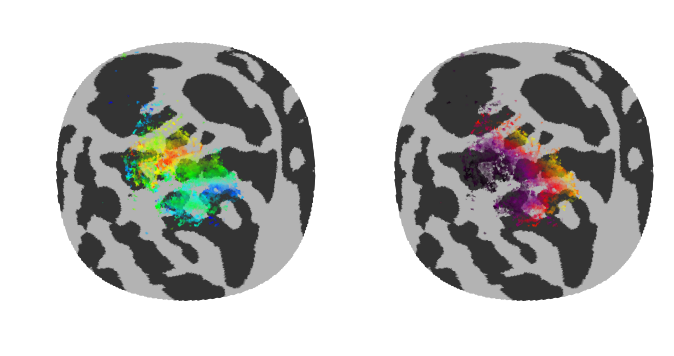

In [39]:
agg = v123.aggregate_prep()
(f, axs) = plt.subplots(1, 2, figsize=(8,4))
cortex_plot(agg['map'], plotter=axs[0], color=vertex_angle_color)
cortex_plot(agg['map'], plotter=axs[1], color=vertex_eccen_color)
for ax in axs: 
    ax.axis('equal')
    ax.axis('off')

### Plots of the Anatomically-defined Retinotopic Templates

The plots in the cell above were registered to our model of polar angle and eccentricity; once these registrations converge, the result is a warping of the retinotopic maps that bring the measured aggregate retinotopic data into alignment with the retinotopic maps of the model.

Given this warping, we could rearrange the above maps such that they align with the model *or* we could apply the inverse of the warping to the model, essentially aligning the model to the retinotopy. This inversion of the warping gives us the retinotopic 'prediction': the retinotopy model warped into alignment with the data. This is plotted here.

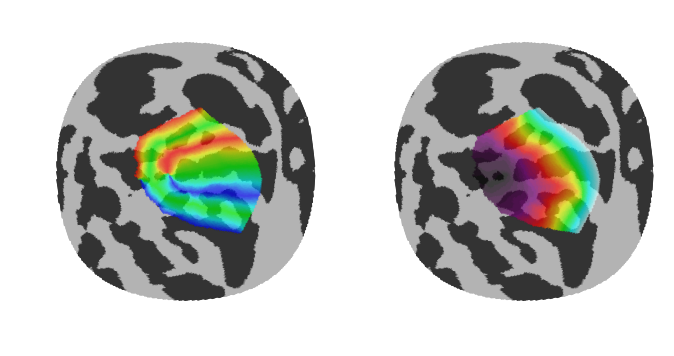

In [58]:
dat  = v123.aggregate_prep()
reg  = v123.aggregate_register()
pred = reg['prediction']
(f, axs) = plt.subplots(1, 2, figsize=(8, 4))
m = agg['map']
m = m.using(
    properties=m.properties.using(
        polar_angle=pred['polar_angle'][m.vertex_labels],
        eccentricity=pred['eccentricity'][m.vertex_labels],
        visual_area=pred['V123_label'][m.vertex_labels],
        weight=(0.65*(~np.isclose(pred['V123_label'][m.vertex_labels], 0)))))
for (a,clr_fn) in zip(axs, [vertex_angle_color, vertex_eccen_color]):
    cortex_plot(m, plotter=a, color=clr_fn)
    a.axis('equal')
    a.axis('off')

## Registration Parameters

The process of registering the measured retinotopic maps to the model of retinotopy has many parameters. These parameters control features of the registration such as the number of steps taken during registration and the relative weights of the terms of the potential/objective function that is minimized. For the most part these parameters can be ignored with the exception of the two just mentiond.

The first of these two parameters mentiond, the number of steps, determines how long the registration should run before concluding. We want to make sure that this number is high enough that we observe reasonable convergence of the solution.

The second of these parameters, the weights of the potential terms, can be reduced to one value: the weight of just the functional-to-model fitting term (the 'model-fitting' weight). The objective function increases both as the fit between functional data and the model improves as well as when the underlying mesh deforms. This encourages the mesh to deform in order to fit the model while simultaneously preventing the mesh from stretching, taring, or deforming more than is desirable. By default, the weight of all terms in the potential function is 1.0 (see the [nben](https://github.com/noahbenson/nben) and [neuropythy](https://github.com/noahbenson/neuropythy) libraries for more details about the potential functions). The functions in this notebook and the v123 package accept an option 'scale', which changes the model-fitting weight.

The two cells below performs registration of the aggregate while varying one of these two parameters. The first cell varies the number of steps taken by the minimization algorithm from 250 to 8000 (taking exponential steps: 250, 500, 1000, etc.). The second cell holds the number of steps at 2000 but varies the weight of the functional-to-model fitting potential function term.

By examining these two parameters, we can determine a few things:
 1. Do small changes in the parameters result in reasonable changes in the resulting fits? We should observe that, for example, decreasing the number of steps or decreasing the scale of the model-fitting weight should both result in slightly less deformation.
 2. Do the predictions converge after a reasonable number of steps? If the predictions that result from 8000 steps of fitting look much different than those produced by 2000 steps of fitting, then we probably aren't minimizing long enough.
 3. If the model-fitting weight is 0, then the result is just the unwarped model itself; as we increase the model-fitting weight, we should see more deformation of the model.

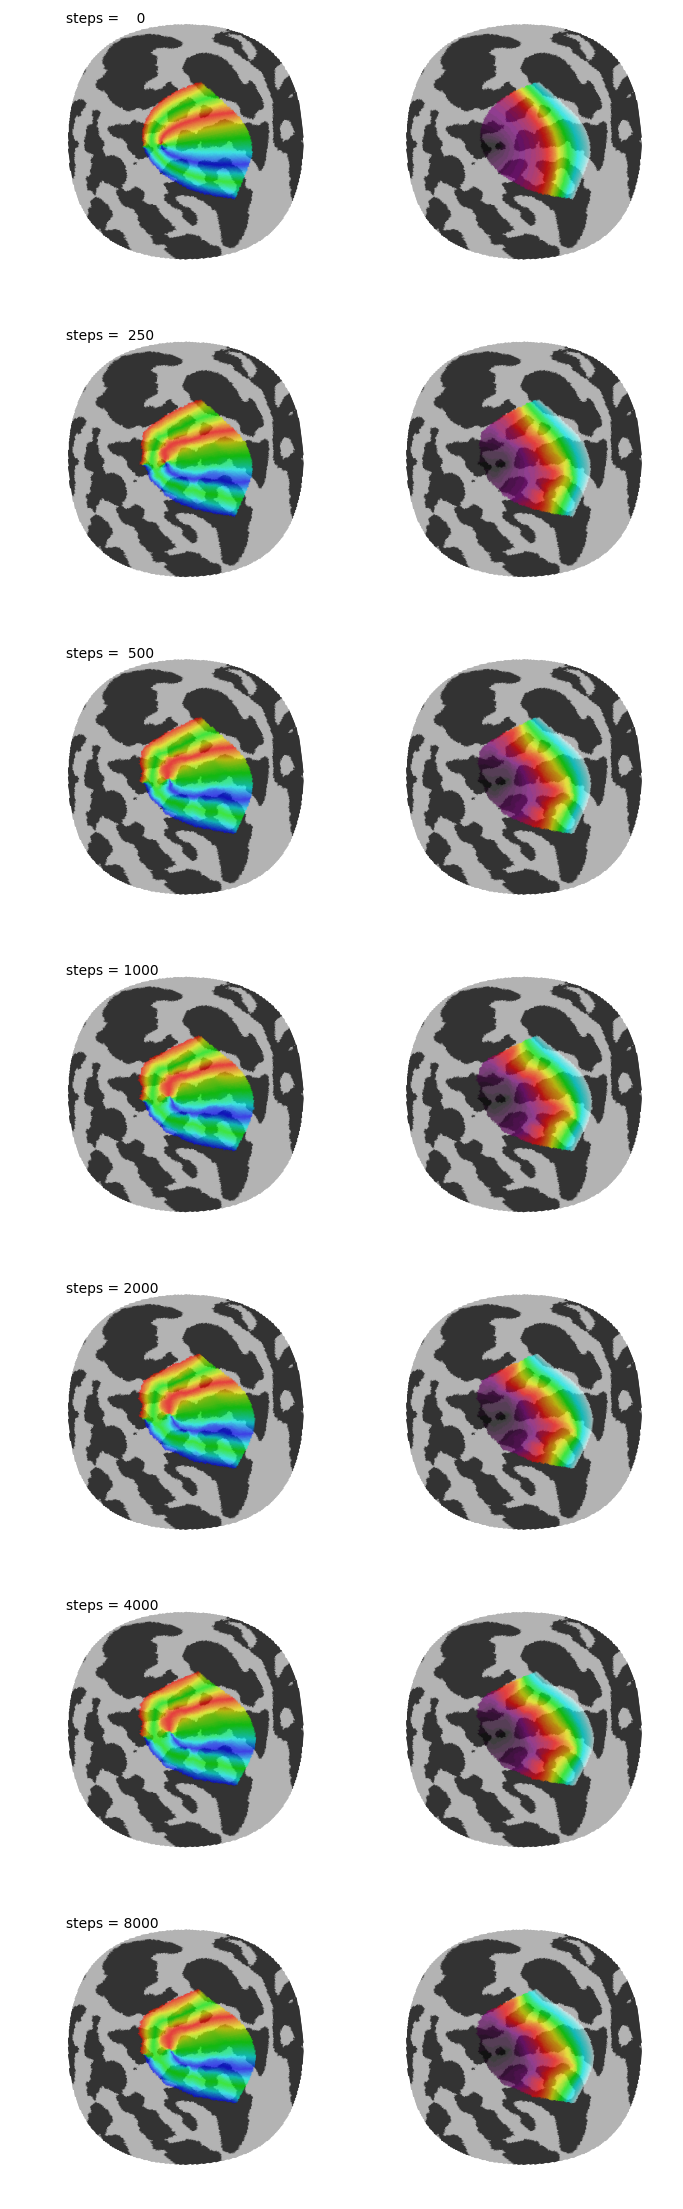

In [56]:
agg_steps = [0, 250, 500, 1000, 2000, 4000, 8000]
agg = v123.aggregate_prep()
agg_regs_by_steps = {k: v123.aggregate_register(scale=1.0, steps=k)
                     for k in agg_steps}
nconds = len(agg_regs_by_steps)
(f, axs) = plt.subplots(nconds, 2, figsize=(8, 4*nconds))
for (s,ax_row) in zip(agg_steps, axs):
    reg  = agg_regs_by_steps[s]
    pred = reg['prediction']
    m = agg['map']
    m = m.using(
        properties=m.properties.using(
            polar_angle=pred['polar_angle'][m.vertex_labels],
            eccentricity=pred['eccentricity'][m.vertex_labels],
            visual_area=pred['V123_label'][m.vertex_labels],
            weight=(0.65*(~np.isclose(pred['V123_label'][m.vertex_labels], 0)))))
    cortex_plot(m, plotter=ax_row[0], color=vertex_angle_color)
    cortex_plot(m, plotter=ax_row[1], color=vertex_eccen_color)
    for a in ax_row:
        a.axis('equal')
        a.axis('off')
    ax_row[0].text(-34, 34, 'steps = %4d' % s);

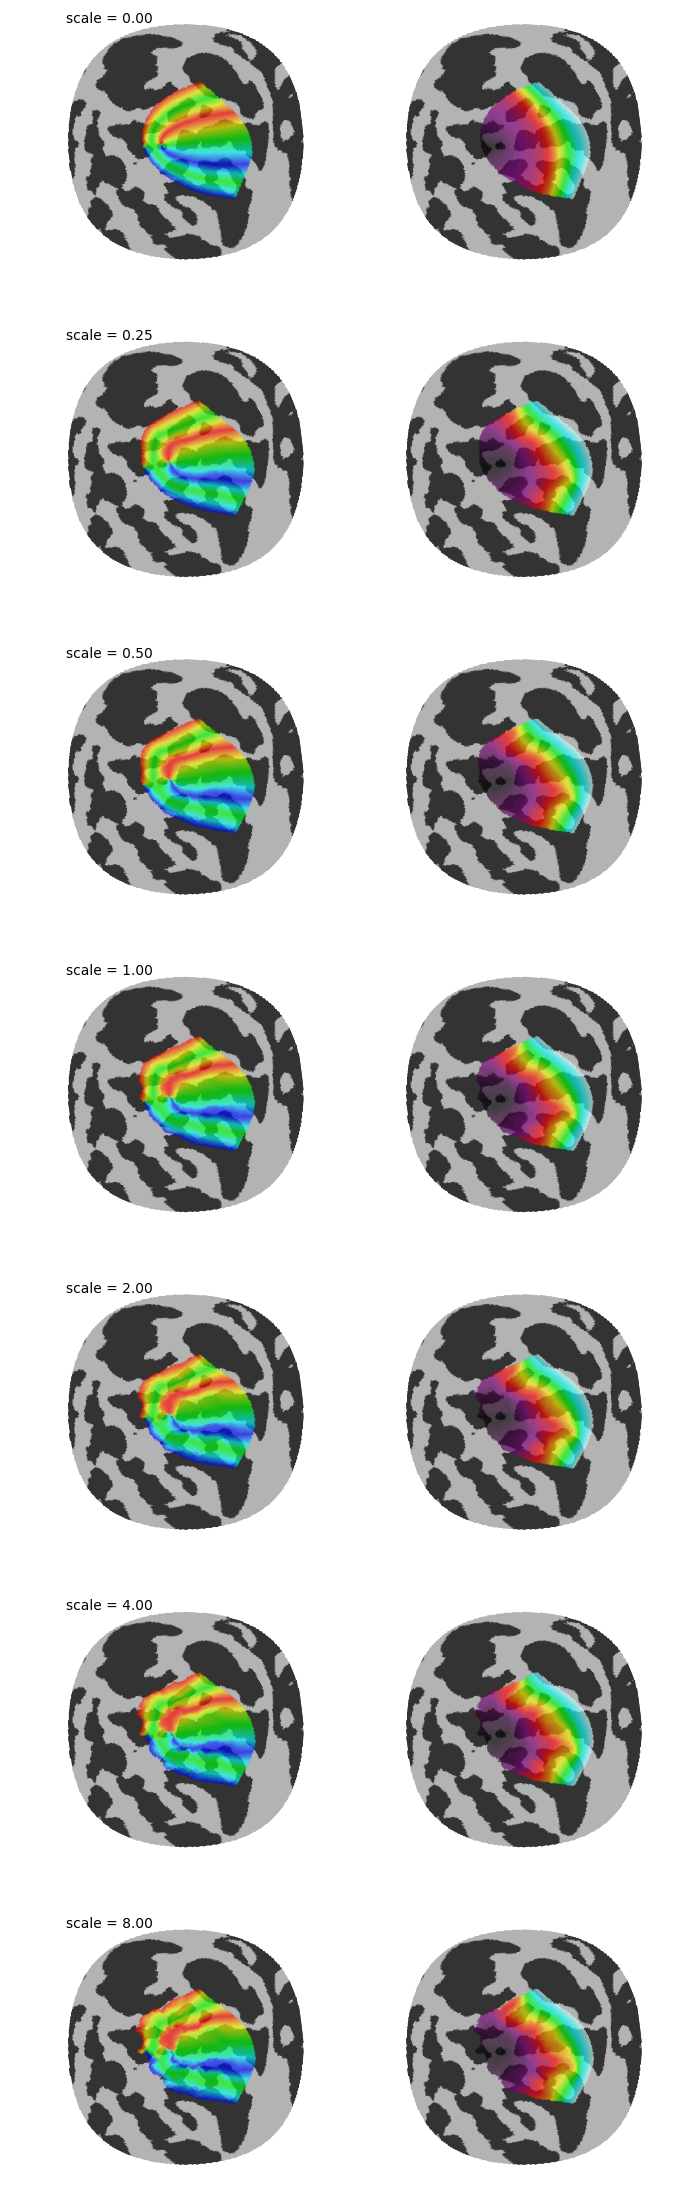

In [51]:
agg_scales = [0.0, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
agg = v123.aggregate_prep()
agg_regs_by_scale = {k: v123.aggregate_register(scale=k, steps=2000)
                     for k in agg_scales}

nconds = len(agg_regs_by_scale)
(f, axs) = plt.subplots(nconds, 2, figsize=(8, 4*nconds))
for (s,ax_row) in zip(agg_scales, axs):
    reg  = agg_regs_by_scale[s]
    pred = reg['prediction']
    m = agg['map']
    m = m.using(
        properties=m.properties.using(
            polar_angle=pred['polar_angle'][m.vertex_labels],
            eccentricity=pred['eccentricity'][m.vertex_labels],
            visual_area=pred['V123_label'][m.vertex_labels],
            weight=(0.65*(~np.isclose(pred['V123_label'][m.vertex_labels], 0)))))
    cortex_plot(m, plotter=ax_row[0], color=vertex_angle_color)
    cortex_plot(m, plotter=ax_row[1], color=vertex_eccen_color)
    for a in ax_row:
        a.axis('equal')
        a.axis('off')
    ax_row[0].text(-34, 34, 'scale = %4.2f' % s);

## Exporting the Aggregate Registrations

The cell below exports the aggregate registration results to the analyses directory in the V123 data root (you can change this by editing the V123_DATA_ROOT environment variable when starting the notebook or by calling v123.data_root(new_data_root) at any time). If you downloaded the full dataset from the OSF, you do not need to run this cell.

In [168]:
agg_scales = [0.0, 0.25, 0.5,  1.0,  2.0,  4.0,  8.0]
agg_steps  = [  0,  250, 500, 1000, 2000, 4000, 8000]

for scale in agg_scales: v123.save_aggregate(scale=scale)
for steps in agg_steps:  v123.save_aggregate(steps=steps)

# Individual Subject Retinotopy Predictions

This section of the notebook applies retintopic templates of V1, V2, and V3 to each individual subject, hemisphere, and dataset. The registration process is outlined in the paper with which this notebook is associated.

For gold-standard datasets (always dataset 0 for every subject), we additionally calculate the cortical magnification using both neighborhood- and path-based metrics. We save these out to the analyses directory.

In [ ]:
for sub in v123.subject_names:
    for hem in ['lh', 'rh']:
        for ds in v123.subject_datasets[sub]:
            # Perform registration and save the result
            v123.save_subject(sub, hem, ds)
        # Also save the cortical magnification, which is calculated for dataset 0
        v123.save_subject_cmag(sub, hem)

In [201]:
ny.cortex = reload(ny.cortex)
ny = reload(ny)
v123 = reload(v123)

for sub in v123.subject_names:
    for hem in ['lh', 'rh']:
        v123.save_subject_cmag(sub, hem)
    print "Finished %s." % sub

Finished S0901.
Finished S0902.
Finished S0903.
Finished S0904.
Finished S0905.
Finished S0906.
Finished S0907.
Finished S1201.
Finished S1901.
